In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from support_code.model2 import DQN
from support_code.env import TradingEnv
from support_code.functions import fetch_data, buy_and_hold, pickle_model, corr

In [2]:
import warnings
warnings.simplefilter('ignore')

---
---
---
### Random back testing

In [6]:
df = fetch_data('goog_df')

starting_balance = 1_000_000

env = TradingEnv(df, balance_init=starting_balance, actions=5)
env.verbose=1

In [7]:
np.random.seed(None)
env.seed(None)

In [8]:
done = False
obs = env.reset()
start = env.current_step

stock_performance = []
model_performance = []
actions = []

while not done:
    
    stock_performance.append(df.loc[env.current_step]['close'])
    model_performance.append(env.net_worth)
        
    action = np.random.randint(env.action_space.n)
    obs, rewards, done, info = env.step(action)

    actions.append(env._actions[action])
    
end = env.current_step

current price 926.5
action 0.0
balance 1000000 shares held 0
previous net worth 1000000 current net worth 1000000.0

current price 929.080017
action 0.5
total possible to buy 1075.2582993085718
number bought 537.6291496542859
cost of buying 499999.99999999994
balance 500000.00000000006 shares held 537.6291496542859
previous net worth 1000000.0 current net worth 999500.4995004996

current price 932.070007
action 0.0
balance 500000.00000000006 shares held 537.6291496542859
previous net worth 999500.4995004996 current net worth 1001108.0052816744

current price 935.090027
action 0.5
total possible to buy 534.1736999409786
number bought 267.0868499704893
cost of buying 250000.0
balance 250000.00000000006 shares held 804.7159996247752
previous net worth 1001108.0052816744 current net worth 1002481.905816463

current price 925.1099849999999
action 1.0
total possible to buy 269.9681700552068
number bought 269.9681700552068
cost of buying 250000.00000000003
balance 2.9103830456733704e-11 share

---

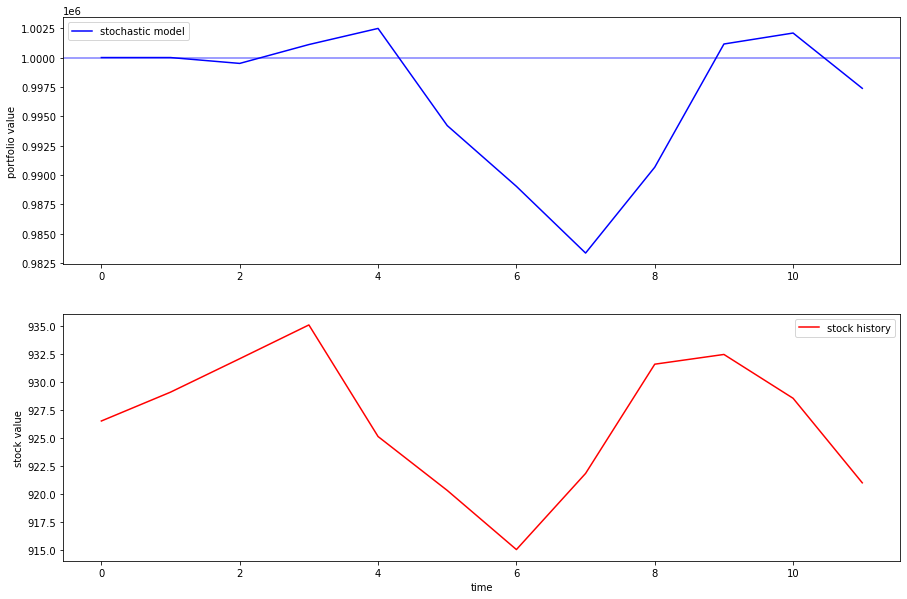

In [9]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(model_performance, 'b-', label='stochastic model')
ax1.set_ylabel('portfolio value')
ax1.axhline(starting_balance, alpha=0.5, color='blue')
ax1.legend()

ax2.plot(stock_performance, 'r-', label='stock history')
ax2.set_ylabel('stock value')
ax2.set_xlabel('time')
ax2.legend()

plt.show();

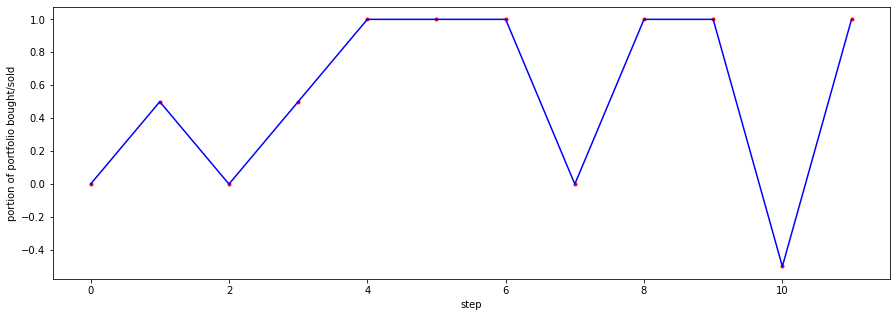

In [10]:
plt.figure(figsize=(15,5))
plt.plot(actions, 'r.')
plt.plot(actions, 'b-')
plt.xlabel('step')
plt.ylabel('portion of portfolio bought/sold')

plt.show();

In [11]:
corr(actions, stock_performance)

0.2578120490770921

---
---
---
### Training/backtesting

In [12]:
df = fetch_data('goog_df')
#df.shape

In [13]:
np.random.seed(None)

starting_balance = 1_000_000

env = TradingEnv(df, balance_init=starting_balance, actions=5)
env.verbose=0
env.seed(None)

#print(env.action_space, env.observation_space)

In [18]:
dqn_solver = DQN(
    action_space=env.action_space.n, 
    state_space=env.observation_space.shape,
    batch_size=64,
    memory_size=1_000_000,
    alpha=1.0,
    alpha_decay=0.999,
    alpha_min=0.1,
    gamma=0.99,
    )

dqn_solver.verbose = 0
dqn_solver.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 942)               29202     
_________________________________________________________________
dense_5 (Dense)              (None, 360)               339480    
_________________________________________________________________
dense_6 (Dense)              (None, 70)                25270     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 355       
Total params: 394,307
Trainable params: 394,307
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = []

In [ ]:
for i in np.arange(813, 2500):
    
    # Reset the evironment at the top of each episode
    state = env.reset()
    
    stock_performance = []
    model_performance = []
    reward_trace = []    
    actions = []
    
    start = env.current_step
    done = False    
    
    # The model will iterate until a terminal state is reached
    while not done:
                
        # Select an action by passing the current observation/state to the DQN
        action = dqn_solver.act(state)
        
        # The environment takes a step according to that action and returns the new state, the reward, and the terminal status
        next_state, reward, done, info = env.step(action)
                
        # Commit to the DQN's memory the relevant information
        dqn_solver.remember(state, action, reward, next_state, done)
        
        # Update the current state
        state = next_state

        actions.append(action)
        reward_trace.append(reward)
        model_performance.append(env.net_worth)  
        stock_performance.append(df.loc[env.current_step]['close'])
            
    print('================================================================================================================')
    print(i+1)
    print('FINAL PROFIT', env.net_worth-env.balance_init)
    print('MEAN REWARD:', np.mean(reward_trace))
    print('DAY RANGE:', start, env.current_step)
    print('EXPLORATION:', dqn_solver.alpha)
    print('MEMORY SIZE:', len(dqn_solver.memory))
    print('================================================================================================================')
    
    # After each episode, perform experience replay
    test = dqn_solver.replay()  
    
    print('\n\n\n')
    
    history.append({
        'stock': stock_performance,
        'model': model_performance,
        'actions': actions,
        'rewards': np.mean(reward_trace),
        })

X, y = test

814
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.021484346981259964
DAY RANGE: 208 212
EXPLORATION: 0.4451229379699419
MEMORY SIZE: 22823




815
FINAL PROFIT 116464.61042903177
MEAN REWARD: -0.017618693591909172
DAY RANGE: 2089 2156
EXPLORATION: 0.44467781503197196
MEMORY SIZE: 22890




816
FINAL PROFIT -147472.79673204082
MEAN REWARD: 0.008442748499293086
DAY RANGE: 653 666
EXPLORATION: 0.44423313721693997
MEMORY SIZE: 22903




817
FINAL PROFIT 117057.22258037026
MEAN REWARD: -0.008350947397738439
DAY RANGE: 158 183
EXPLORATION: 0.44378890407972305
MEMORY SIZE: 22928




818
FINAL PROFIT 67664.21863727551
MEAN REWARD: 0.01538927131717267
DAY RANGE: 62 72
EXPLORATION: 0.44334511517564335
MEMORY SIZE: 22938




819
FINAL PROFIT -999.0009990008548
MEAN REWARD: -0.018730080243424863
DAY RANGE: 97 100
EXPLORATION: 0.4429017700604677
MEMORY SIZE: 22941




820
FINAL PROFIT 2985.7743009284604
MEAN REWARD: -0.011302331639300625
DAY RANGE: 307 319
EXPLORATION: 0.44245886829040726
MEMORY S





837
FINAL PROFIT -38085.66613021714
MEAN REWARD: -0.021845193300664187
DAY RANGE: 2270 2306
EXPLORATION: 0.43499694211384704
MEMORY SIZE: 23500




838
FINAL PROFIT -20241.48060526536
MEAN REWARD: 0.018083009876290152
DAY RANGE: 2322 2327
EXPLORATION: 0.4345619451717332
MEMORY SIZE: 23505




839
FINAL PROFIT 126973.48462265427
MEAN REWARD: 0.008258482908150828
DAY RANGE: 1846 1955
EXPLORATION: 0.43412738322656147
MEMORY SIZE: 23614




840
FINAL PROFIT 7228.729770444799
MEAN REWARD: -0.02075463528458875
DAY RANGE: 553 568
EXPLORATION: 0.4336932558433349
MEMORY SIZE: 23629




841
FINAL PROFIT 581.4120363811962
MEAN REWARD: 0.01897355103519756
DAY RANGE: 1185 1196
EXPLORATION: 0.43325956258749154
MEMORY SIZE: 23640




842
FINAL PROFIT 12385.207446810091
MEAN REWARD: -0.030564481287758214
DAY RANGE: 1874 1918
EXPLORATION: 0.43282630302490405
MEMORY SIZE: 23684




843
FINAL PROFIT 96895.95396926999
MEAN REWARD: -0.008114972985956426
DAY RANGE: 625 633
EXPLORATION: 0.432393476721879





860
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 2203 2204
EXPLORATION: 0.4251013001293033
MEMORY SIZE: 24315




861
FINAL PROFIT -37554.54146009707
MEAN REWARD: 0.011411966402596235
DAY RANGE: 311 331
EXPLORATION: 0.424676198829174
MEMORY SIZE: 24335




862
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1064 1065
EXPLORATION: 0.4242515226303448
MEMORY SIZE: 24336




863
FINAL PROFIT 39864.17107810441
MEAN REWARD: -0.05802474682089214
DAY RANGE: 209 260
EXPLORATION: 0.42382727110771445
MEMORY SIZE: 24387




864
FINAL PROFIT -84319.17588036205
MEAN REWARD: 0.02820690888723234
DAY RANGE: 514 558
EXPLORATION: 0.4234034438366067
MEMORY SIZE: 24431




865
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1734 1735
EXPLORATION: 0.4229800403927701
MEMORY SIZE: 24432




866
FINAL PROFIT 10988.124883337412
MEAN REWARD: 0.0040151886928291355
DAY RANGE: 919 923
EXPLORATION: 0.42255706035237733
MEMORY SIZE: 24436




867
FINAL PROFIT -28647.145101627





883
FINAL PROFIT -40524.382010031724
MEAN REWARD: -0.019562507040069243
DAY RANGE: 337 360
EXPLORATION: 0.41543077175087
MEMORY SIZE: 24727




884
FINAL PROFIT -3656.77372467448
MEAN REWARD: -0.05187077915640507
DAY RANGE: 214 240
EXPLORATION: 0.41501534097911913
MEMORY SIZE: 24753




885
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.009590222434825496
DAY RANGE: 265 267
EXPLORATION: 0.41460032563814003
MEMORY SIZE: 24755




886
FINAL PROFIT 13719.593574827071
MEAN REWARD: -0.011072928324301273
DAY RANGE: 577 588
EXPLORATION: 0.4141857253125019
MEMORY SIZE: 24766




887
FINAL PROFIT 52578.03460103716
MEAN REWARD: 0.00830728066168754
DAY RANGE: 1804 1832
EXPLORATION: 0.41377153958718943
MEMORY SIZE: 24794




888
FINAL PROFIT 9395.035371048609
MEAN REWARD: 0.009581898989919747
DAY RANGE: 1524 1526
EXPLORATION: 0.4133577680476022
MEMORY SIZE: 24796




889
FINAL PROFIT 77127.51310502877
MEAN REWARD: 0.0006866366576402215
DAY RANGE: 1892 1929
EXPLORATION: 0.4129444102795546
MEMOR





906
FINAL PROFIT 67803.60604432598
MEAN REWARD: -0.02482975269104603
DAY RANGE: 624 669
EXPLORATION: 0.4059802359226587
MEMORY SIZE: 25184




907
FINAL PROFIT -50461.47497305425
MEAN REWARD: 0.0067672381122202245
DAY RANGE: 1757 1778
EXPLORATION: 0.40557425568673605
MEMORY SIZE: 25205




908
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 2199 2200
EXPLORATION: 0.40516868143104934
MEMORY SIZE: 25206




909
FINAL PROFIT 71562.78410643665
MEAN REWARD: -0.00018466486629283493
DAY RANGE: 1225 1266
EXPLORATION: 0.4047635127496183
MEMORY SIZE: 25247




910
FINAL PROFIT -135164.9286435434
MEAN REWARD: 0.010869791084059936
DAY RANGE: 536 597
EXPLORATION: 0.4043587492368687
MEMORY SIZE: 25308




911
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1334 1335
EXPLORATION: 0.4039543904876318
MEMORY SIZE: 25309




912
FINAL PROFIT -62849.87711760658
MEAN REWARD: 0.006480926357786178
DAY RANGE: 1768 1789
EXPLORATION: 0.4035504360971442
MEMORY SIZE: 25330




913
FINA





929
FINAL PROFIT 144043.67040715134
MEAN REWARD: -0.018323093222917423
DAY RANGE: 133 212
EXPLORATION: 0.3967446880864632
MEMORY SIZE: 25847




930
FINAL PROFIT 264366.2972004991
MEAN REWARD: -0.0031079704590279
DAY RANGE: 1635 1668
EXPLORATION: 0.3963479433983767
MEMORY SIZE: 25880




931
FINAL PROFIT -24389.809257343644
MEAN REWARD: 0.014665438944229349
DAY RANGE: 1468 1487
EXPLORATION: 0.3959515954549783
MEMORY SIZE: 25899




932
FINAL PROFIT 96073.79149094038
MEAN REWARD: 0.017809611363186553
DAY RANGE: 505 834
EXPLORATION: 0.39555564385952335
MEMORY SIZE: 26228




933
FINAL PROFIT -9000.43737474794
MEAN REWARD: -0.0013220688169788355
DAY RANGE: 786 853
EXPLORATION: 0.39516008821566384
MEMORY SIZE: 26295




934
FINAL PROFIT -51281.03488394816
MEAN REWARD: 0.00202638205198014
DAY RANGE: 1142 1208
EXPLORATION: 0.3947649281274482
MEMORY SIZE: 26361




935
FINAL PROFIT -3463.5895124844974
MEAN REWARD: -0.029428819925246333
DAY RANGE: 158 161
EXPLORATION: 0.3943701631993207
ME





952
FINAL PROFIT -13321.928306961432
MEAN REWARD: -0.0182899444672112
DAY RANGE: 713 736
EXPLORATION: 0.3877192375315819
MEMORY SIZE: 27346




953
FINAL PROFIT -80749.49657678988
MEAN REWARD: -0.039919118310372724
DAY RANGE: 1453 1498
EXPLORATION: 0.3873315182940503
MEMORY SIZE: 27391




954
FINAL PROFIT 51365.82637216733
MEAN REWARD: 0.0053152995092578745
DAY RANGE: 173 179
EXPLORATION: 0.38694418677575626
MEMORY SIZE: 27397




955
FINAL PROFIT -15494.546300329734
MEAN REWARD: -0.0015579297034031133
DAY RANGE: 1871 1898
EXPLORATION: 0.3865572425889805
MEMORY SIZE: 27424




956
FINAL PROFIT -25274.22208706825
MEAN REWARD: 0.004830766948122487
DAY RANGE: 1154 1162
EXPLORATION: 0.38617068534639154
MEMORY SIZE: 27432




957
FINAL PROFIT -5233.269535176922
MEAN REWARD: 0.010387299556989034
DAY RANGE: 1299 1307
EXPLORATION: 0.38578451466104513
MEMORY SIZE: 27440




958
FINAL PROFIT -80777.3850786608
MEAN REWARD: -0.004947361456925394
DAY RANGE: 1820 1844
EXPLORATION: 0.38539873014





975
FINAL PROFIT -74105.76407865132
MEAN REWARD: -0.015273259914066861
DAY RANGE: 935 971
EXPLORATION: 0.3788991048049279
MEMORY SIZE: 28160




976
FINAL PROFIT 12667.44351906213
MEAN REWARD: -0.006909153417160667
DAY RANGE: 1933 1971
EXPLORATION: 0.37852020570012296
MEMORY SIZE: 28198




977
FINAL PROFIT 12638.967414158746
MEAN REWARD: -0.009782272187143748
DAY RANGE: 2276 2288
EXPLORATION: 0.37814168549442284
MEMORY SIZE: 28210




978
FINAL PROFIT 33225.3282723343
MEAN REWARD: -0.01080048972296418
DAY RANGE: 775 781
EXPLORATION: 0.3777635438089284
MEMORY SIZE: 28216




979
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 29 30
EXPLORATION: 0.3773857802651195
MEMORY SIZE: 28217




980
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 2182 2183
EXPLORATION: 0.37700839448485435
MEMORY SIZE: 28218




981
FINAL PROFIT 17392.85078383831
MEAN REWARD: 0.011358649794644753
DAY RANGE: 1225 1228
EXPLORATION: 0.3766313860903695
MEMORY SIZE: 28221




982
FINAL PROF





998
FINAL PROFIT 12276.252633259282
MEAN REWARD: -0.01357442594878179
DAY RANGE: 1502 1601
EXPLORATION: 0.3702796191800558
MEMORY SIZE: 29030




999
FINAL PROFIT 28114.133110772003
MEAN REWARD: -0.008762891337215105
DAY RANGE: 1369 1382
EXPLORATION: 0.36990933956087574
MEMORY SIZE: 29043




1000
FINAL PROFIT 1715.6659699799493
MEAN REWARD: -0.009650610343085429
DAY RANGE: 1202 1206
EXPLORATION: 0.36953943022131486
MEMORY SIZE: 29047




1001
FINAL PROFIT 1857.696134223137
MEAN REWARD: 0.01395457894343941
DAY RANGE: 645 647
EXPLORATION: 0.3691698907910935
MEMORY SIZE: 29049




1002
FINAL PROFIT 124764.70837926725
MEAN REWARD: -0.02528866510158004
DAY RANGE: 2245 2286
EXPLORATION: 0.3688007209003024
MEMORY SIZE: 29090




1003
FINAL PROFIT 11050.28643254051
MEAN REWARD: -0.022832183587311438
DAY RANGE: 1992 2014
EXPLORATION: 0.36843192017940213
MEMORY SIZE: 29112




1004
FINAL PROFIT 42219.316574290744
MEAN REWARD: 0.015325545007304061
DAY RANGE: 467 539
EXPLORATION: 0.3680634882





1020
FINAL PROFIT -21389.20116078609
MEAN REWARD: -0.025473182506547894
DAY RANGE: 2329 2356
EXPLORATION: 0.3622184346183837
MEMORY SIZE: 29877




1021
FINAL PROFIT 24336.10557794571
MEAN REWARD: -0.014378336917459293
DAY RANGE: 769 790
EXPLORATION: 0.36185621618376534
MEMORY SIZE: 29898




1022
FINAL PROFIT 20438.900478393654
MEAN REWARD: -0.054016663592802716
DAY RANGE: 920 947
EXPLORATION: 0.36149435996758156
MEMORY SIZE: 29925




1023
FINAL PROFIT 24757.9494752608
MEAN REWARD: 2.337858717946982e-05
DAY RANGE: 1364 1428
EXPLORATION: 0.361132865607614
MEMORY SIZE: 29989




1024
FINAL PROFIT 61642.4640500946
MEAN REWARD: -0.022377589348775602
DAY RANGE: 626 633
EXPLORATION: 0.36077173274200636
MEMORY SIZE: 29996




1025
FINAL PROFIT -72.52720926143229
MEAN REWARD: -0.02014364674856336
DAY RANGE: 2331 2338
EXPLORATION: 0.36041096100926434
MEMORY SIZE: 30003




1026
FINAL PROFIT -1.662781203049235
MEAN REWARD: -0.007127697479504538
DAY RANGE: 147 155
EXPLORATION: 0.36005055004

1042
FINAL PROFIT -14117.561217258452
MEAN REWARD: 0.022414654457460676
DAY RANGE: 1870 1879
EXPLORATION: 0.35433274633890316
MEMORY SIZE: 30322




1043
FINAL PROFIT 19971.849766053143
MEAN REWARD: -0.0038969020925289162
DAY RANGE: 2104 2132
EXPLORATION: 0.35397841359256427
MEMORY SIZE: 30350




1044
FINAL PROFIT -12382.623084969819
MEAN REWARD: 0.0032838661927058195
DAY RANGE: 1099 1134
EXPLORATION: 0.3536244351789717
MEMORY SIZE: 30385




1045
FINAL PROFIT 9182.543868053472
MEAN REWARD: -0.0075655105859612675
DAY RANGE: 2200 2209
EXPLORATION: 0.35327081074379274
MEMORY SIZE: 30394




1046
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1512 1513
EXPLORATION: 0.352917539933049
MEMORY SIZE: 30395




1047
FINAL PROFIT -6334.508072414203
MEAN REWARD: 0.0013385865344771072
DAY RANGE: 1467 1477
EXPLORATION: 0.3525646223931159
MEMORY SIZE: 30405




1048
FINAL PROFIT 4634.325522726867
MEAN REWARD: 0.004966465356292862
DAY RANGE: 239 242
EXPLORATION: 0.3522120577707228
MEMOR





1065
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 690 691
EXPLORATION: 0.34627211496036764
MEMORY SIZE: 31778




1066
FINAL PROFIT 116778.04028057656
MEAN REWARD: -0.006230123183405027
DAY RANGE: 1672 1705
EXPLORATION: 0.3459258428454073
MEMORY SIZE: 31811




1067
FINAL PROFIT -11604.133714726428
MEAN REWARD: -0.004404295247259705
DAY RANGE: 2075 2087
EXPLORATION: 0.34557991700256185
MEMORY SIZE: 31823




1068
FINAL PROFIT -33653.11480224528
MEAN REWARD: 0.006900882317969502
DAY RANGE: 762 781
EXPLORATION: 0.3452343370855593
MEMORY SIZE: 31842




1069
FINAL PROFIT -12134.531572552165
MEAN REWARD: -0.08634170866987152
DAY RANGE: 606 771
EXPLORATION: 0.34488910274847373
MEMORY SIZE: 32007




1070
FINAL PROFIT 156562.90424454492
MEAN REWARD: -0.005298193784006959
DAY RANGE: 976 1028
EXPLORATION: 0.34454421364572524
MEMORY SIZE: 32059




1071
FINAL PROFIT 27381.326945801615
MEAN REWARD: -0.023625993604409534
DAY RANGE: 785 817
EXPLORATION: 0.3441996694320795
MEMORY





1088
FINAL PROFIT -51077.30299344286
MEAN REWARD: -0.02381775576019912
DAY RANGE: 1317 1379
EXPLORATION: 0.33839485296807126
MEMORY SIZE: 32859




1089
FINAL PROFIT 20680.83995947754
MEAN REWARD: -0.006653037872650032
DAY RANGE: 50 60
EXPLORATION: 0.3380564581151032
MEMORY SIZE: 32869




1090
FINAL PROFIT -14878.079167218879
MEAN REWARD: 0.02788647306306468
DAY RANGE: 1187 1201
EXPLORATION: 0.33771840165698813
MEMORY SIZE: 32883




1091
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 285 286
EXPLORATION: 0.33738068325533116
MEMORY SIZE: 32884




1092
FINAL PROFIT 2651.8282672741916
MEAN REWARD: 0.005574459743661535
DAY RANGE: 1653 1656
EXPLORATION: 0.3370433025720758
MEMORY SIZE: 32887




1093
FINAL PROFIT 116604.7595443814
MEAN REWARD: -0.05845632558874714
DAY RANGE: 58 103
EXPLORATION: 0.33670625926950376
MEMORY SIZE: 32932




1094
FINAL PROFIT -15152.119646378327
MEAN REWARD: 0.027647503225413005
DAY RANGE: 753 774
EXPLORATION: 0.33636955301023425
MEMORY SIZE: 

---

In [21]:
i = -1

In [22]:
long = buy_and_hold(
    balance_init=env.balance_init,
    back_prices=history[i]['stock'],
    fee=env.fee
    )

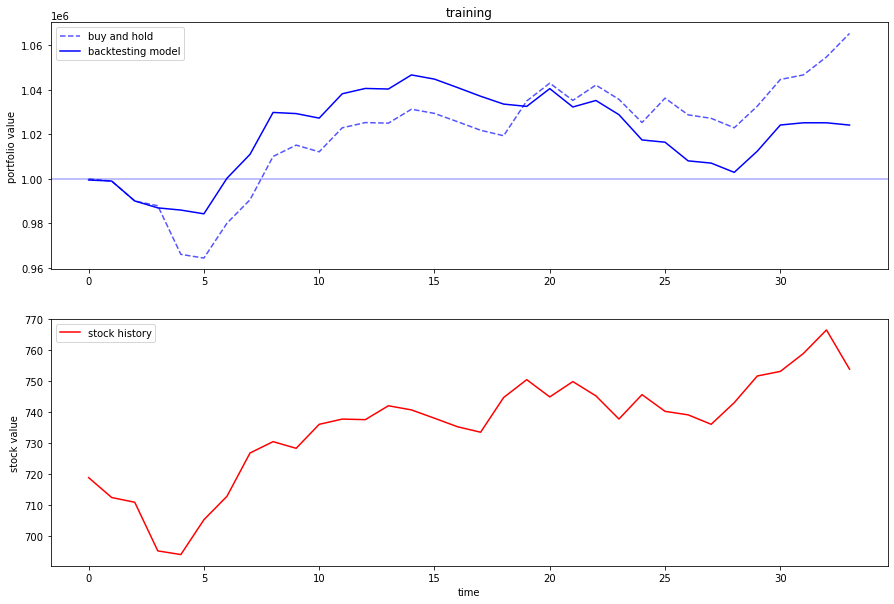

In [23]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(long, 'b--', alpha=0.667, label='buy and hold')
ax1.plot(history[i]['model'], 'b-', label='backtesting model')
ax1.axhline(env.balance_init, alpha=0.333, color='blue')
ax1.set_ylabel('portfolio value')
ax1.set_title('training')
ax1.legend()

ax2.plot(history[i]['stock'], 'r-', label='stock history')
ax2.set_ylabel('stock value')
ax2.set_xlabel('time')
ax2.legend()

plt.show();

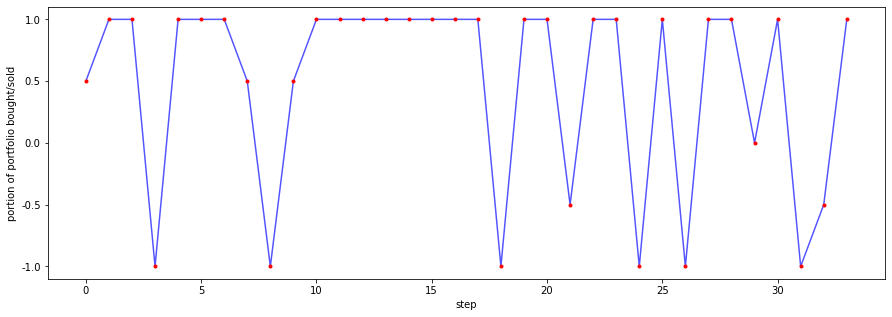

In [24]:
plt.figure(figsize=(15,5))
plt.plot(history[i]['actions'], 'b-', alpha=0.6667)
plt.plot(history[i]['actions'], 'r.')

plt.yticks(np.arange(dqn_solver.action_space), np.linspace(-1,1, dqn_solver.action_space))
plt.xlabel('step')
plt.ylabel('portion of portfolio bought/sold')
plt.show();

In [25]:
rewards = np.array([history[i]['rewards'] for i in np.arange(len(history))])

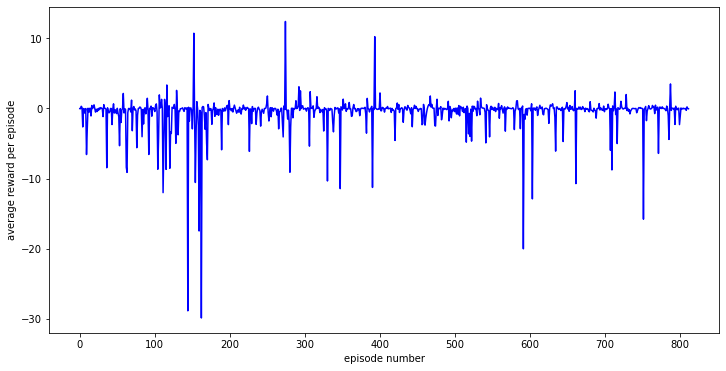

In [27]:
plt.figure(figsize=(12,6))
plt.plot(rewards, 'b-')
plt.xlabel('episode number')
plt.ylabel('average reward per episode')
plt.show();

In [ ]:
print(corr(history[i]['stock'], history[i]['actions']))

---

In [ ]:
pickle_model(dqn_solver, path='model_info_goog_3')

---
---
---
### Model testing

In [ ]:
env = TradingEnv(df, balance_init=1000, training=False)

In [ ]:
dqn_solver.alpha = 0
dqn_solver.alpha_min = 0
dqn_solver.is_fit = True
dqn_solver.replay();

In [ ]:
state = env.reset()

stock_performance = []
model_performance = []
reward_trace = []    
actions = []

start = env.current_step
done = False    

# The model will iterate until a terminal state is reached
while not done:

    # Select an action by passing the current observation/state to the DQN
    action = dqn_solver.act(state)

    # The environment takes a step according to that action and returns the new state, the reward, and the terminal status
    next_state, reward, done, info = env.step(action)

    # Commit to the DQN's memory the relevant information
    dqn_solver.remember(state, action, reward, next_state, done)

    # Update the current state
    state = next_state

    actions.append(action)
    reward_trace.append(reward)
    model_performance.append(env.net_worth)  
    stock_performance.append(df.loc[env.current_step]['close'])

In [ ]:
long = buy_and_hold(
    balance_init=env.balance_init,
    back_prices=stock_performance,
    fee=env.fee,
    )

In [ ]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(long, 'b--', alpha=0.667, label='buy and hold')
ax1.plot(model_performance, 'b-', label='backtesting model')
ax1.axhline(env.balance_init, alpha=0.333, color='blue')
ax1.set_ylabel('portfolio value')
ax1.legend()

ax2.plot(stock_performance, 'r-', label='stock history')
ax2.set_ylabel('stock value')
ax2.set_xlabel('time')
ax2.legend()